In [1]:
from pyscf import gto, scf, cc

# Define the NH3 molecule in minimal basis set
mol = gto.Mole()
mol.atom = '''
N  0.000000  0.000000  0.000000
H  0.000000  0.000000  1.000000
H  0.000000  0.943000 -0.333000
H  0.000000 -0.943000 -0.333000
'''
mol.basis = 'sto-3g'  # Minimal basis set
mol.symmetry = True
mol.build()

#!/usr/bin/env python

'''
Using the CCSD method as the active space solver to compute an approximate
CASCI energy.

See also 42-oo_ccd.py

A wrapper is required to adapt the CCSD solver to CASCI fcisolver interface.
Inside the wrapper function, the CCSD code is the same as the example
40-ccsd_with_given_hamiltonian.py
'''

import numpy
from pyscf import gto, scf, cc, ao2mo, mcscf

class AsFCISolver(object):
    def __init__(self):
        self.mycc = None

    def kernel(self, h1, h2, norb, nelec, ci0=None, ecore=0, **kwargs):
        fakemol = gto.M(verbose=0)
        nelec = numpy.sum(nelec)
        fakemol.nelectron = nelec
        fake_hf = scf.RHF(fakemol)
        fake_hf._eri = ao2mo.restore(8, h2, norb)
        fake_hf.get_hcore = lambda *args: h1
        fake_hf.get_ovlp = lambda *args: numpy.eye(norb)
        fake_hf.kernel()
        self.mycc = cc.CCSD(fake_hf)
        eris = self.mycc.ao2mo()
        e_corr, t1, t2 = self.mycc.kernel(eris=eris)
        l1, l2 = self.mycc.solve_lambda(t1, t2, eris=eris)
        e_tot = self.mycc.e_tot + ecore
        eee,cee = self.mycc.eeccsd(nroots=10)
        print("----------------excited states",e_tot+eee)
        return e_tot, CCSDAmplitudesAsCIWfn([t1, t2, l1, l2])

    def make_rdm1(self, fake_ci, norb, nelec):
        t1, t2, l1, l2 = fake_ci.cc_amplitues
        dm1 = self.mycc.make_rdm1(t1, t2, l1, l2, ao_repr=True)
        return dm1

    def make_rdm12(self, fake_ci, norb, nelec):
        t1, t2, l1, l2 = fake_ci.cc_amplitues
        dm2 = self.mycc.make_rdm2(t1, t2, l1, l2, ao_repr=True)
        return self.make_rdm1(fake_ci, norb, nelec), dm2

    def spin_square(self, fake_ci, norb, nelec):
        return 0, 1

class CCSDAmplitudesAsCIWfn:
    def __init__(self, cc_amplitues):
        self.cc_amplitues = cc_amplitues


r_bohr = 1.8897259886
mol = gto.M(atom = 'N 0 0 0; H 0 0 1.40; H 0.950353 0 -0.336000; H -0.475176 -0.823029 -0.336000',
            basis = 'sto3g',
            verbose = 4)
mf = scf.RHF(mol).run()

norb = 6
nelec = 6
mc = mcscf.CASCI(mf, norb, nelec)
mc.fcisolver = AsFCISolver()
mc.kernel()

System: uname_result(system='Darwin', node='pssrivathsans-MacBook-Pro.local', release='20.6.0', version='Darwin Kernel Version 20.6.0: Thu Jul  6 22:12:47 PDT 2023; root:xnu-7195.141.49.702.12~1/RELEASE_X86_64', machine='x86_64')  Threads 4
Python 3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 14:43:12) [Clang 14.0.6 ]
numpy 2.2.2  scipy 1.13.0  h5py 3.11.0
Date: Thu Apr 10 21:00:56 2025
PySCF version 2.6.2
PySCF path  /Users/cwq/CodingwithQiskit/miniconda3/envs/cwq/lib/python3.12/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 10
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bo

/Users/cwq/CodingwithQiskit/miniconda3/envs/cwq/lib/python3.12/site-packages/pyscf/gto/mole.py:1284: UserWarning: Function mol.dumps drops attribute _nelectron because it is not JSON-serializable
  warnings.warn(msg)


----------------excited states [-55.23146155 -55.23146154 -55.23146154 -55.17775928 -55.11562629
 -55.11562629 -55.11562629 -54.95808166 -54.95808166 -54.89332487]
Density matrix diagonal elements [1.98184313 1.93754517 1.97351338 0.07681777 0.01323735 0.0170432 ]
CASCI E = -55.4328426910943  E(CI) = -10.4889840407816  S^2 = 0.0000000


(np.float64(-55.432842691094294),
 np.float64(-10.48898404078163),
 array([[ 9.93686466e-01, -2.20466945e-01, -1.21009752e-07,
         -4.00012531e-02, -7.73658403e-02,  1.08160495e-01,
         -1.35309140e-01,  9.81601953e-07],
        [ 2.95573290e-02,  7.54538458e-01,  6.70081048e-07,
          2.14614637e-01,  3.85625992e-01, -6.17197093e-01,
          9.50400938e-01, -7.39799781e-06],
        [ 2.19055788e-03,  6.35959540e-02,  5.03993315e-01,
         -1.49137437e-01, -4.10713865e-01, -7.00496127e-02,
          2.96194885e-01,  9.27836644e-01],
        [-3.79417188e-03, -1.10151974e-01,  2.90980954e-01,
          2.58312543e-01,  7.11377453e-01,  1.21329291e-01,
         -5.13010523e-01,  5.35691550e-01],
        [-9.11877887e-04, -3.83520709e-02,  4.59432698e-07,
          5.17235708e-01, -3.49075531e-01, -6.88408808e-01,
         -5.66969472e-01,  4.03547854e-06],
        [-3.30952345e-03,  8.72159987e-02,  5.06994067e-07,
          5.34696020e-01, -2.36988891e-01,  9.1010542

In [1]:
import numpy as np
eig14 = np.array([-55.43103616178108, -55.2260562 , -55.17055885, -55.10424189, -54.93488344,
        -54.90184305, -54.88845817, -54.86948105, -54.86725946,
        -54.82107145, -54.80714301, -54.73800183, -54.73423032,
        -54.69969389, -54.65922956, -54.65558427, -54.64911249,
        -54.64780247, -54.63361937, -54.62403776, -54.58649393,
        -54.57642545, -54.56538149, -54.55849624, -54.55705229,
        -54.52868059, -54.52012246, -54.5075323 , -54.50193568,
        -54.4896991 , -54.45665193, -54.44338241, -54.43573517,
        -54.4350206 , -54.42378846, -54.41770902, -54.4126933 ,
        -54.40205291, -54.3871642 , -54.38706688, -54.38345852,
        -54.36642199, -54.36206713, -54.34756368, -54.34269202,
        -54.3386668 , -54.33092026, -54.30696457, -54.30599234,
        -54.30370825, -54.29039005, -54.27412868, -54.26905744,
        -54.25515925, -54.25206608, -54.23922921, -54.23402236,
        -54.23054442, -54.2242725 , -54.21818908, -54.20610384,
        -54.20376455, -54.19340528, -54.18331905, -54.18242143,
        -54.17441478, -54.17189932, -54.16305533, -54.13246902,
        -54.12620525, -54.11934993, -54.11276055, -54.09700111,
        -54.07865414, -54.07669442, -54.07603293, -54.06389334,
        -54.05287825, -54.04876575, -54.03881342, -54.00885647,
        -54.00297329, -53.99765788, -53.97800324, -53.97469342,
        -53.95411142, -53.94690943, -53.9451936 , -53.9381503 ,
        -53.91064301, -53.90844412, -53.90027773, -53.89628568,
        -53.87430233, -53.86161491, -53.86086031, -53.84630449,
        -53.83980317, -53.83310222, -53.83134886, -53.79972179,
        -53.79110286, -53.77579018, -53.76800984, -53.76265735,
        -53.75642142, -53.72936063, -53.71361397, -53.70346018,
        -53.64913915, -53.63590656, -53.63289034, -53.61256669,
        -53.56025961, -53.53497653, -53.44562121, -53.43731797,
        -53.4192589])

len(eig14)

118

In [7]:
eom_ccsd = np.array([-55.23146155, -55.23146154, -55.23146154, -55.17775928, -55.11562629,
 -55.11562629, -55.11562629, -54.95808166, -54.95808166, -54.89332487])

In [2]:
from pyscf import gto, scf, mcscf
 
# Define the molecule
mol = gto.M(
    atom='N 0.0 0.0 0.0; H 0.0 0.0 1.40; H 0.950353 0.0 -0.336000; H -0.475176 -0.823029 -0.336000;',
    basis='sto-3g',
    verbose=1  # Optional: Adjusts verbosity for output
)
 
# Perform Restricted Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()
 
# Get the HF energy
hf_energy = mf.e_tot
print("Hartree-Fock Ground State Energy:", hf_energy)
 
# Define the active space
ncas = 6  # Number of active orbitals - spatial it seems
nelecas = 6  # Number of electrons in the active space
 
# Set up the CASCI/CASSCF solver
mycas = mcscf.CASCI(mf, ncas, nelecas)
 
 
mycas.fcisolver.nroots=118
 
# Compute the CASCI/CASSCF energy
e_casci = mycas.kernel()
 
# Output the results
print("CASCI/CASSCF Ground State Energy:", e_casci)
print("Hartree-Fock Ground State Energy:", hf_energy)

Hartree-Fock Ground State Energy: -55.36867363184639
CASCI/CASSCF Ground State Energy: (array([-55.43307445, -55.2325252 , -55.17833671, -55.11583142,
       -54.96016324, -54.91717704, -54.89913672, -54.8946028 ,
       -54.8853115 , -54.8382119 , -54.82716462, -54.75663832,
       -54.74100932, -54.72021515, -54.68356181, -54.67464093,
       -54.66644394, -54.65934986, -54.64766021, -54.64610722,
       -54.63510078, -54.62736659, -54.59802881, -54.58073523,
       -54.57562859, -54.56275186, -54.55634252, -54.53971464,
       -54.53757717, -54.51698674, -54.51137195, -54.50571142,
       -54.50234833, -54.4915714 , -54.48136615, -54.46590962,
       -54.4521669 , -54.45093614, -54.43654756, -54.43368175,
       -54.42986974, -54.40327659, -54.39751687, -54.39481545,
       -54.3945768 , -54.38126509, -54.3667319 , -54.35881197,
       -54.34815827, -54.34247318, -54.33919052, -54.32918166,
       -54.30186817, -54.29800408, -54.29650936, -54.29301464,
       -54.28872619, -54.28058

In [4]:
fenergies14 = np.array([-55.43307445, -55.2325252 , -55.17833671, -55.11583142,
       -54.96016324, -54.91717704, -54.89913672, -54.8946028 ,
       -54.8853115 , -54.8382119 , -54.82716462, -54.75663832,
       -54.74100932, -54.72021515, -54.68356181, -54.67464093,
       -54.66644394, -54.65934986, -54.64766021, -54.64610722,
       -54.63510078, -54.62736659, -54.59802881, -54.58073523,
       -54.57562859, -54.56275186, -54.55634252, -54.53971464,
       -54.53757717, -54.51698674, -54.51137195, -54.50571142,
       -54.50234833, -54.4915714 , -54.48136615, -54.46590962,
       -54.4521669 , -54.45093614, -54.43654756, -54.43368175,
       -54.42986974, -54.40327659, -54.39751687, -54.39481545,
       -54.3945768 , -54.38126509, -54.3667319 , -54.35881197,
       -54.34815827, -54.34247318, -54.33919052, -54.32918166,
       -54.30186817, -54.29800408, -54.29650936, -54.29301464,
       -54.28872619, -54.28058294, -54.25911897, -54.25413225,
       -54.25242907, -54.24915045, -54.24418703, -54.23584134,
       -54.22351535, -54.20051317, -54.19934776, -54.19348691,
       -54.18916789, -54.1874655 , -54.17205715, -54.15595343,
       -54.15536265, -54.14039864, -54.13790119, -54.13343474,
       -54.13074563, -54.1081979 , -54.10238297, -54.08063841,
       -54.07740529, -54.07142118, -54.06493911, -54.04312604,
       -54.02580652, -54.02398335, -54.01958567, -54.01792145,
       -54.00778657, -53.9970074 , -53.98657438, -53.9806678 ,
       -53.97875147, -53.97460065, -53.96814588, -53.96573434,
       -53.9643527 , -53.95964097, -53.95319949, -53.9505334 ,
       -53.9504531 , -53.94275656, -53.94049244, -53.93909307,
       -53.92974697, -53.92446444, -53.91903484, -53.91363859,
       -53.91319344, -53.90813175, -53.89888582, -53.89861971,
       -53.89238072, -53.88626197, -53.8758424 , -53.87439045,
       -53.8681639 , -53.86382531])

len(fenergies14)

118

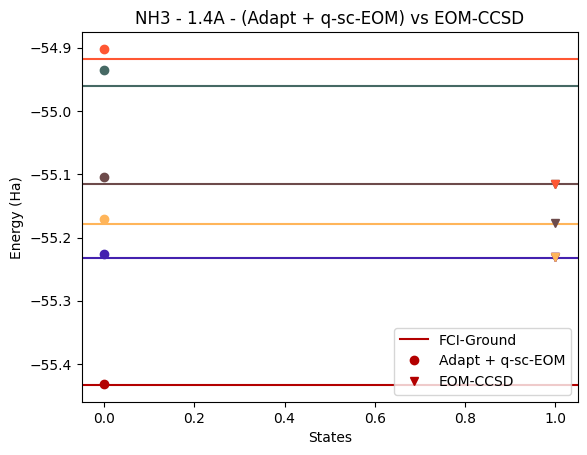

In [9]:
import matplotlib.pyplot as plt


plt.axhline(y=fenergies14[0], color="#b30000", linestyle='-', label='FCI-Ground')
plt.axhline(y=fenergies14[1], color="#4421af", linestyle='-')
plt.axhline(y=fenergies14[2], color="#ffb55a", linestyle='-')
plt.axhline(y=fenergies14[3], color="#6d4b4b", linestyle='-')
plt.axhline(y=fenergies14[4], color="#466964", linestyle='-')
plt.axhline(y=fenergies14[5], color="#FF5733", linestyle='-')


plt.plot(0, eig14[0],'o', color = '#b30000', label = 'Adapt + q-sc-EOM') 
plt.plot(0, eig14[1], 'o', color = '#4421af')
plt.plot(0, eig14[2], 'o', color = '#ffb55a')
plt.plot(0, eig14[3], 'o', color = '#6d4b4b')
plt.plot(0, eig14[4], 'o', color = '#466964')
plt.plot(0, eig14[5], 'o', color = '#FF5733')


plt.plot(1, eom_ccsd[0],'v', color = '#b30000', label = 'EOM-CCSD') 
plt.plot(1, eom_ccsd[1], 'v', color = '#4421af')
plt.plot(1, eom_ccsd[2], 'v', color = '#ffb55a')
plt.plot(1, eom_ccsd[3], 'v', color = '#6d4b4b')
plt.plot(1, eom_ccsd[4], 'v', color = '#466964')
plt.plot(1, eom_ccsd[5], 'v', color = '#FF5733')

plt.legend()
plt.xlabel('States')
plt.ylabel('Energy (Ha)')
plt.title('NH3 - 1.4A - (Adapt + q-sc-EOM) vs EOM-CCSD')

plt.show()